In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 34.8 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=8a02b8815f57bb61dabd4a438e583323e88f35671799f865a9c67b4bdb53f043
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.0 

In [8]:
import torch
import torch.nn as nn
import numpy as np

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class GraphConvolution(torch.nn.Module):
    def __init__(self, character_embedding_dim, edge_dim):
        super(GraphConvolution, self).__init__()

        self.ce_dim = character_embedding_dim
        self.e_dim = edge_dim
        
        self.message_to_listener = nn.Sequential(nn.Linear(character_embedding_dim + edge_dim, character_embedding_dim),
                                                 nn.Tanh())
        
        self.message_to_speaker = nn.Sequential(nn.Linear(character_embedding_dim + edge_dim, character_embedding_dim),
                                                 nn.Tanh())
        
        self.listener_update = nn.Sequential(nn.Linear(character_embedding_dim, character_embedding_dim), nn.Tanh())
        self.speaker_update = nn.Sequential(nn.Linear(character_embedding_dim, character_embedding_dim), nn.Tanh())

    def forward(self, character_embeddings, dialogue_embeddings, speakers, listeners):
        '''
          -> (speakers intersect listeners) should be an empty set!
        '''

        character_embeddings = character_embeddings.detach()

        speaker_features = character_embeddings[speakers, :]
        listener_features = character_embeddings[listeners, :]

        speaker_listener_dialogue =  torch.cat((speaker_features - listener_features, dialogue_embeddings), dim=-1)

        # Residual connection included to avoid dying gradients
        updated_speakers = self.speaker_update(speaker_features + self.message_to_listener(speaker_listener_dialogue)) + speaker_features 
        updated_listeners = self.listener_update(listener_features + self.message_to_speaker(speaker_listener_dialogue)) + listener_features 

        out = character_embeddings.clone()
        out[speakers, :] = updated_speakers
        out[listeners, :] = updated_listeners

        return out

class GCLWithHeadBert(torch.nn.Module):
  def __init__(self, character_embedding_dim, bert_dim, edge_dim, out_dim):
    super(GCLWithHeadBert, self).__init__()

    self.bert_dim = bert_dim
    self.head = nn.Linear(2 * character_embedding_dim, out_dim)
    self.edge_translator = nn.Linear(bert_dim, edge_dim)
    self.gcn_layer = GraphConvolution(character_embedding_dim, edge_dim)
    self.activation = nn.Tanh()

  def forward(self, character_embeddings, embedding, speaker, listener):
    edge_feature = self.activation(self.edge_translator(embedding.detach())[None, :])
    updated_embeddings = self.gcn_layer(character_embeddings, edge_feature, speaker, listener)
    linear_layer_out = self.activation(self.head(torch.cat((updated_embeddings[speaker, :], updated_embeddings[listener, :]), axis=1)))
    return updated_embeddings, linear_layer_out


In [5]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df_dialogs = pd.read_csv('rj_vadr_bert.csv').drop(columns=["Unnamed: 0"])
character_enum = pd.DataFrame(df_dialogs["speaker"].unique()).reset_index().rename(columns={0:'character'})
df_dialogs_with_speaker_enumeration = pd.merge(left=df_dialogs,
                                       right=character_enum,
                                       left_on="speaker",
                                       right_on="character",
                                       how="left").rename(columns={'index': 'speaker_index'}).drop(columns=['character'])
df_dialogs_with_listener_enumeration = pd.merge(left=df_dialogs_with_speaker_enumeration,
                                       right=character_enum,
                                       left_on="listener",
                                       right_on="character",
                                       how="left").rename(columns={'index': 'listener_index'}).drop(columns=['character'])
data_d = df_dialogs_with_listener_enumeration[['speaker', 'listener', 'speaker_index', 'listener_index', 'dialogue', 'dialogue_sentiment', 'avg_sentiment', 'bert']]
data = data_d.T.drop_duplicates().T

Mounted at /content/drive


In [6]:
train_data = data.iloc[:int(0.6*len(data))]
test_data = data.iloc[int(0.6*len(data)):]

Total dialogues: 1011


0it [00:00, ?it/s]

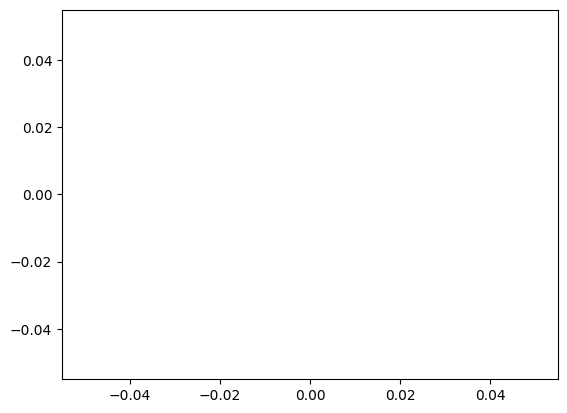

200it [00:04, 36.67it/s]

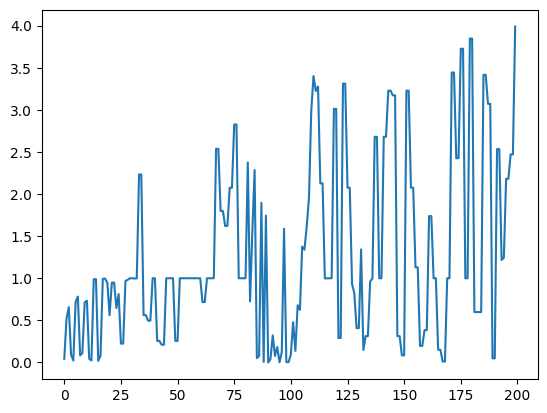

396it [00:09, 53.06it/s]

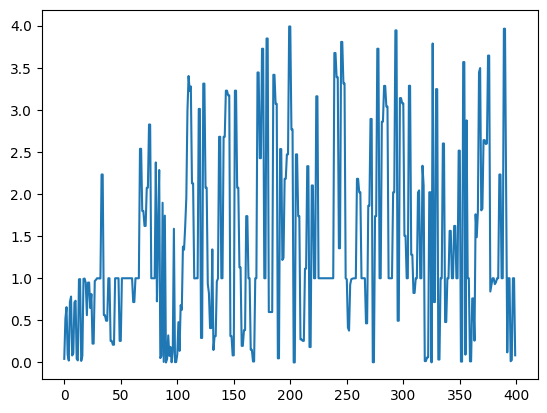

600it [00:13, 55.40it/s]

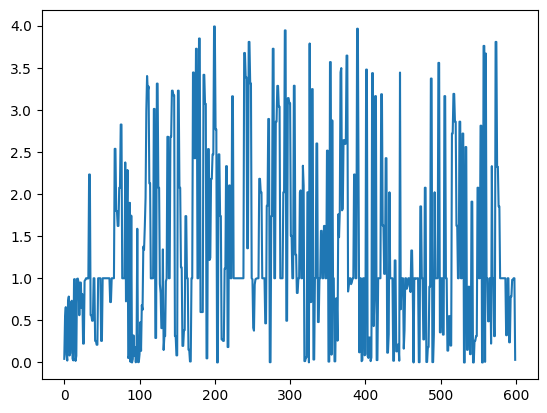

797it [00:17, 42.63it/s]

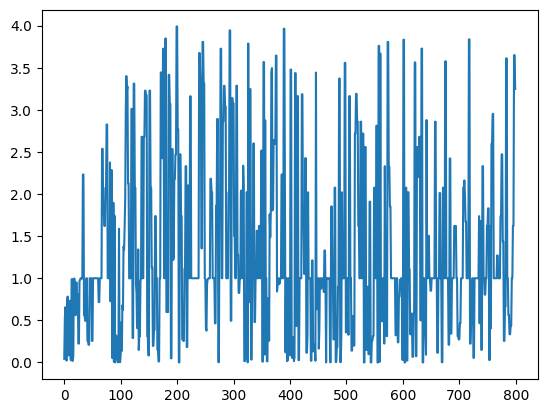

998it [00:24, 50.45it/s]

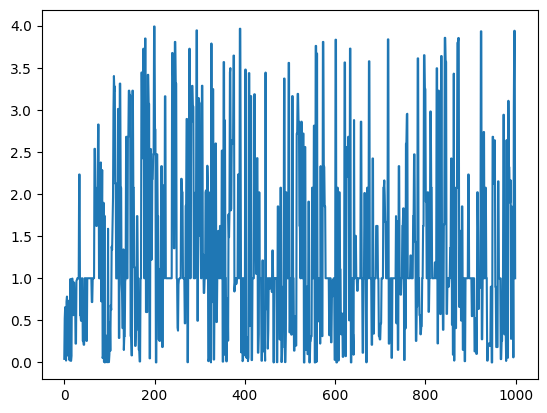

1011it [00:24, 40.93it/s]


In [17]:

import tqdm
import matplotlib.pyplot as plt

character_embedding_dim = 16
bert_dim = 768
edge_dim = 16

gcl_wh_bert = GCLWithHeadBert(character_embedding_dim, bert_dim, edge_dim, 1).to(torch_device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gcl_wh_bert.parameters())

ITERS = 10
NUM_ITERS = 10

n_characters = len(character_enum)
character_embeddings = torch.ones((n_characters, character_embedding_dim)).to(torch_device)

torch.autograd.set_detect_anomaly(True)

losses = {}
all_losses = []

print('Total dialogues:', len(train_data))
for i in range(ITERS):
  for index, row in tqdm.tqdm(train_data.iterrows()):
    for j in range(NUM_ITERS):
      y = torch.tensor(row['dialogue_sentiment']).view(-1, 1).to(torch_device)
      
      # Forward pass: Compute predicted y by passing x to the model
      bert_row = np.array([float(val) for val in row['bert'].strip('][').split(', ')])
      bert_embed = torch.from_numpy(bert_row).float().to(torch_device)
      speaker = torch.tensor([row['speaker_index']]).to(torch_device)
      listener = torch.tensor([row['listener_index']]).to(torch_device)

      character_embeddings, y_pred = gcl_wh_bert(character_embeddings, bert_embed, speaker, 
                                            listener)
      
      # Compute and print loss
      loss = criterion(y_pred, y)

      # Zero gradients, perform a backward pass, and update the weights.
      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()

      if index % 1000 == 0 and j == NUM_ITERS - 1:
        plt.plot(all_losses)
        plt.show()


      chars = [row['speaker'], row['listener']]
      chars.sort()
      key = chars[0] + ';' + chars[1]
      losses[key] = losses.get(key, [])
      losses[key].append(loss.cpu().detach().numpy())

      all_losses += [float(loss.cpu().detach().numpy())]



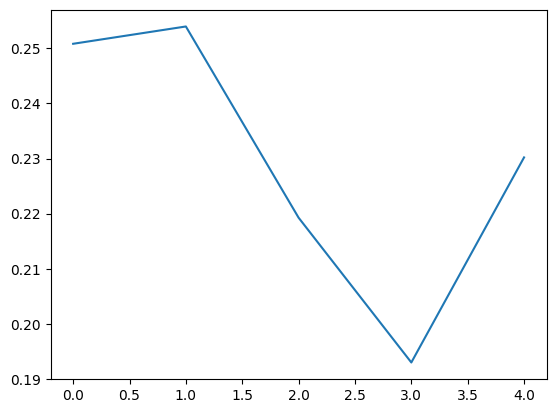

In [ ]:
def get_avg_losses(loss, size):
    """
    For the list of losses, create a new list averaging together every size elements
    """
    avg_loss = []
    for i in range(0, len(loss), size):
        avg_loss.append(sum(loss[i:i+size])/size)
    return avg_loss[:-1]
  
avg_losses = get_avg_losses(all_losses, 1011)
plt.plot(avg_losses)

675it [00:15, 44.73it/s]


accuracy 0.6488888888888888
With error margin 0.1, accuracy = 0.15703703703703703
With error margin 0.2, accuracy = 0.23555555555555555
With error margin 0.3, accuracy = 0.2740740740740741
With error margin 0.4, accuracy = 0.30814814814814817
With error margin 0.5, accuracy = 0.33925925925925926
With error margin 0.6, accuracy = 0.3496296296296296
With error margin 0.7, accuracy = 0.35555555555555557
With error margin 0.8, accuracy = 0.36148148148148146
With error margin 0.9, accuracy = 0.3688888888888889
With error margin 1, accuracy = 0.6414814814814814
With error margin 0.1, accuracy = 0.07111111111111111
With error margin 0.2, accuracy = 0.11407407407407408
With error margin 0.3, accuracy = 0.15407407407407409
With error margin 0.4, accuracy = 0.2074074074074074
With error margin 0.5, accuracy = 0.2577777777777778
With error margin 0.6, accuracy = 0.30666666666666664
With error margin 0.7, accuracy = 0.3362962962962963
With error margin 0.8, accuracy = 0.35259259259259257
With erro

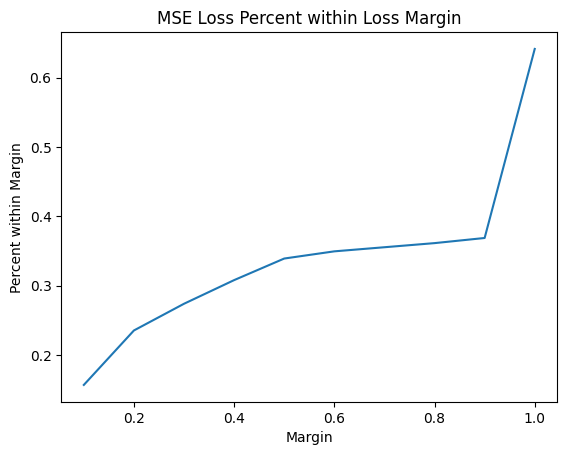

In [18]:
correct, incorrect = 0, 0
diffs = []
losses = []
criterion = torch.nn.MSELoss()
for index, row in tqdm.tqdm(test_data.iterrows()):
    y = torch.tensor(row['dialogue_sentiment']).view(-1, 1).to(torch_device)
    
    # Forward pass: Compute predicted y by passing x to the model
    bert_row = np.array([float(val) for val in row['bert'].strip('][').split(', ')])
    bert_embed = torch.from_numpy(bert_row).float().to(torch_device)
    speaker = torch.tensor([row['speaker_index']]).to(torch_device)
    listener = torch.tensor([row['listener_index']]).to(torch_device)

    character_embeddings, y_pred = gcl_wh_bert(character_embeddings, bert_embed, speaker, 
                                          listener)
    
    # if y_pred and y are both positive, update correct
    if (y_pred.item() > 0 and y.item() > 0) or (y_pred.item() < 0 and y.item() < 0):
        correct += 1
    else: 
        incorrect += 1
    
    diffs.append(abs(y_pred.item() - y.item()))
    losses.append(abs(criterion(y_pred, y).item()))


# printing correctness/incorrect measured by direction
print('accuracy', incorrect/(correct + incorrect))

# printing accuracy based on loss
import numpy as np
loss_np = np.array(losses)
accuracies = []
for boundary in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
  boolean = loss_np[loss_np <= boundary]
  print(f"With error margin {boundary}, accuracy = {len(boolean) / len(loss_np)}")
  accuracies.append(len(boolean) / len(loss_np))
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], accuracies, label='MSE Loss')
plt.xlabel('Margin')
plt.ylabel('Percent within Margin')
plt.title('MSE Loss Percent within Loss Margin')

# printing accuracy based on loss
import numpy as np
diff_np = np.array(diffs)
accuracies = []
for boundary in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
  boolean = diff_np[diff_np <= boundary]
  print(f"With error margin {boundary}, accuracy = {len(boolean) / len(diff_np)}")
  accuracies.append(len(boolean) / len(loss_np))
#plt.plot(accuracies, label="Abs Diff Loss")

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px

# create a 2D plot of the vectors
def plot_2d(vectors, labels):
    tsne = TSNE(n_components=2, perplexity=1, random_state=0)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(vectors)
    labels = labels

    df = px.data.iris()
    fig = px.scatter(x=T[:,0], y=T[:,1], color=labels)
    fig.show()

In [ ]:
plot_2d(character_embeddings.cpu().detach().numpy(), character_enum['character'])

In [19]:
character_translation = {index: name for index, name in enumerate(character_enum['character'])}

In [20]:
juliet_side = ["JULIET", "NURSE", "LADY CAPULET", "CAPULET"]
romeo_side = ["ROMEO", "FRIAR LAWRENCE", "FRIAR JOHN", "BALTHASAR", "MERCUTIO", "BENVOLIO", "MONTAGUE"]
evil_side = ["TYBALT", "PARIS", "PRINCE", "APOTHECARY"]

name_to_index = {v:k for k,v in character_translation.items()}
juliet_indices = [name_to_index[name] for name in juliet_side]
romeo_indices = [name_to_index[name] for name in romeo_side]
evil_indices = [name_to_index[name] for name in evil_side]

juliet_friends = [character_embeddings[index].detach().cpu().numpy() for index in juliet_indices]
romeo_friends = [character_embeddings[index].detach().cpu().numpy() for index in romeo_indices]
evil_friends = [character_embeddings[index].detach().cpu().numpy() for index in evil_indices]

juliet = juliet_friends[0]
romeo = romeo_friends[0]

juliet_distances = [np.linalg.norm(juliet - friend) for friend in juliet_friends]
romeo_distances = [np.linalg.norm(romeo - friend) for friend in romeo_friends]

juliet_romeo_distances = [np.linalg.norm(juliet - other) for other in romeo_friends]
juliet_evil_distances = [np.linalg.norm(juliet - other) for other in evil_friends]

romeo_juliet_distances = [np.linalg.norm(romeo - other) for other in juliet_friends]
romeo_evil_distances = [np.linalg.norm(romeo - other) for other in evil_friends]

print(np.mean(juliet_distances), np.mean(juliet_romeo_distances), np.mean(juliet_evil_distances))
print(np.mean(romeo_distances), np.mean(romeo_juliet_distances), np.mean(romeo_evil_distances))

439.7364 839.60925 982.7593
990.9806 1005.0215 1274.4503
